In [99]:
import os                       # for working with files
import numpy as np              # for numerical computationss
import pandas as pd             # for working with dataframes
import torch                    # Pytorch module
import matplotlib.pyplot as plt # for plotting informations on graph and images using tensors
import torch.nn as nn           # for creating  neural networks
from torch.utils.data import DataLoader # for dataloaders
from PIL import Image           # for checking images
import torch.nn.functional as F # for functions for calculating loss
import torchvision.transforms as transforms   # for transforming images into tensors
from torchvision.utils import make_grid       # for data checking
from torchvision.datasets import ImageFolder  # for working with classes and images
from torchsummary import summary              # for getting the summary of our model
from torchvision import transforms, datasets
from torchviz import make_dot

%matplotlib inline

In [3]:
!kaggle datasets download -d vipoooool/new-plant-diseases-dataset

Dataset URL: https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset
License(s): copyright-authors
100% 2.70G/2.70G [00:15<00:00, 121MB/s]
100% 2.70G/2.70G [00:15<00:00, 186MB/s]


In [4]:
from zipfile import ZipFile
file_name = '/content/new-plant-diseases-dataset.zip'

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [5]:
data_dir = "/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)"
train_dir = data_dir + "/train"
valid_dir = data_dir + "/valid"
diseases = os.listdir(train_dir)

In [6]:
print(diseases)
print("Total disease classes: {}".format(len(diseases)))

['Peach___healthy', 'Apple___Apple_scab', 'Potato___healthy', 'Potato___Early_blight', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Peach___Bacterial_spot', 'Orange___Haunglongbing_(Citrus_greening)', 'Raspberry___healthy', 'Apple___Black_rot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Cherry_(including_sour)___healthy', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Cherry_(including_sour)___Powdery_mildew', 'Tomato___Early_blight', 'Grape___healthy', 'Blueberry___healthy', 'Tomato___Late_blight', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Pepper,_bell___healthy', 'Corn_(maize)___healthy', 'Pepper,_bell___Bacterial_spot', 'Strawberry___Leaf_scorch', 'Tomato___Tomato_mosaic_virus', 'Corn_(maize)___Common_rust_', 'Grape___Black_rot', 'Tomato___Leaf_Mold', 'Tomato___Bacterial_spot', 'Apple___healthy', 'Apple___Cedar_apple_rust', 'Tomato___healthy', 'Strawberry___healthy', 'Potato___Late_blight', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Gr

In [7]:
diseases_tomato = [
    "Tomato___Bacterial_spot",
    "Tomato___Early_blight",
    "Tomato___Late_blight",
    "Tomato___Leaf_Mold",
    "Tomato___Septoria_leaf_spot",
    "Tomato___Spider_mites Two-spotted_spider_mite",
    "Tomato___Target_Spot",
    "Tomato___Tomato_Yellow_Leaf_Curl_Virus",
    "Tomato___Tomato_mosaic_virus",
    "Tomato___healthy"
]

In [8]:
plants = []
NumberOfDiseases = 0
for plant in diseases_tomato:
    if plant.split('___')[0] not in plants:
        plants.append(plant.split('___')[0])
    if plant.split('___')[1] != 'healthy':
        NumberOfDiseases += 1

In [9]:
# unique plants in the dataset
print(f"Unique Tumbuhan: \n{plants}")
print("jumlah classes: {}".format(NumberOfDiseases))

Unique Tumbuhan: 
['Tomato']
jumlah classes: 9


In [10]:
# Number of images for each disease
nums = {}
for disease in diseases_tomato:
    nums[disease] = len(os.listdir(train_dir + '/' + disease))

# converting the nums dictionary to pandas dataframe passing index as plant name and number of images as column

img_per_class = pd.DataFrame(nums.values(), index=nums.keys(), columns=["no. of images"])
img_per_class

no. of images
Tomato___Bacterial_spot                                 1702
Tomato___Early_blight                                   1920
Tomato___Late_blight                                    1851
Tomato___Leaf_Mold                                      1882
Tomato___Septoria_leaf_spot                             1745
Tomato___Spider_mites Two-spotted_spider_mite           1741
Tomato___Target_Spot                                    1827
Tomato___Tomato_Yellow_Leaf_Curl_Virus                  1961
Tomato___Tomato_mosaic_virus                            1790
Tomato___healthy                                        1926

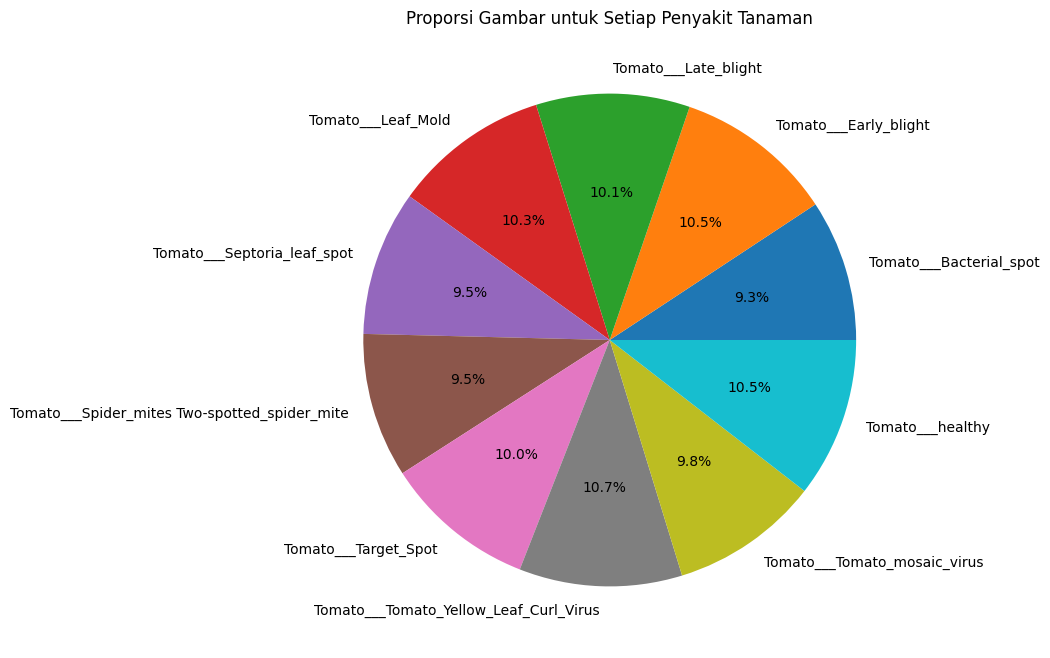

In [94]:
plt.figure(figsize=(8, 8))
plt.pie(list(nums.values()), labels=diseases_tomato, autopct='%1.1f%%')
plt.title('Proporsi Gambar untuk Setiap Penyakit Tanaman')
plt.show()

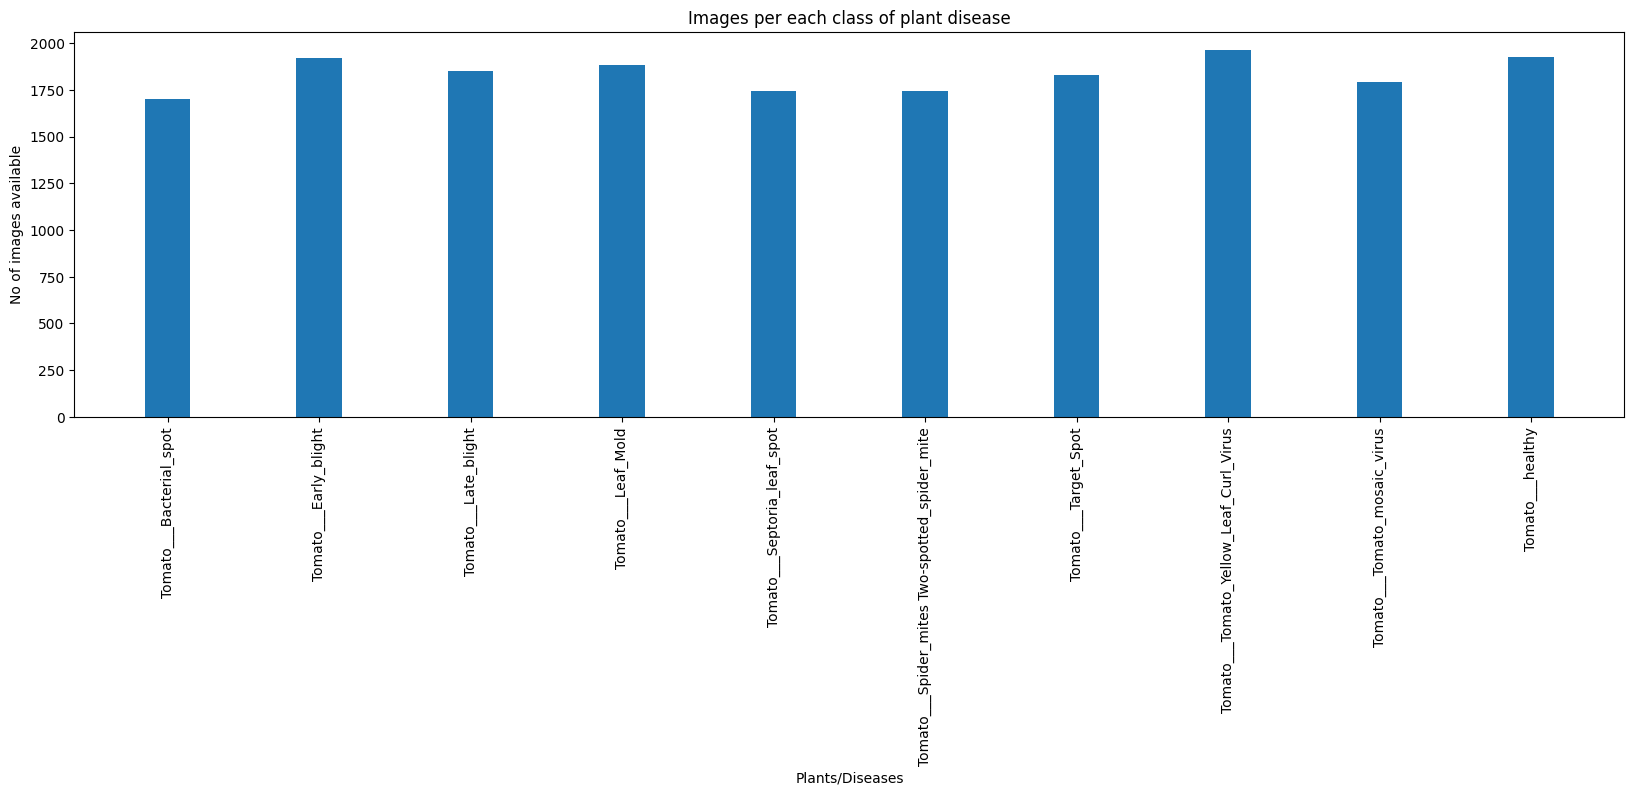

In [11]:
# Plotting number of images available for each disease
index = list(range(len(diseases_tomato)))
plt.figure(figsize=(20, 5))
plt.bar(index, list(nums.values()), width=0.3)
plt.xlabel('Plants/Diseases', fontsize=10)
plt.ylabel('No of images available', fontsize=10)
plt.xticks(index, diseases_tomato, fontsize=10, rotation=90)  # Adjusted fontsize for better readability
plt.title('Images per each class of plant disease')
plt.show()

In [32]:
class TomatoDataset(datasets.ImageFolder):
    def __init__(self, root, transform=None):
        super().__init__(root, transform)

        # Map the original class indices to the new filtered class indices
        tomato_class_indices = {self.class_to_idx[disease]: i for i, disease in enumerate(diseases_tomato)}

        # Filter the samples to only include those with tomato class indices
        filtered_samples = []
        for path, original_label in self.samples:
            if original_label in tomato_class_indices:
                new_label = tomato_class_indices[original_label]
                filtered_samples.append((path, new_label))

        self.samples = filtered_samples
        self.targets = [s[1] for s in self.samples]
        self.classes = diseases_tomato
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}


In [33]:
# datasets for validation and training
train_transform = transforms.Compose([transforms.ToTensor()])
valid_transform = transforms.Compose([transforms.ToTensor()])

train_dataset = TomatoDataset(train_dir, transform=train_transform)
valid_dataset = TomatoDataset(valid_dir, transform=valid_transform)

In [34]:
print(f' {len(train_dataset.samples)} gambar untuk training')

 18345 gambar untuk training


In [35]:
img, label = train_dataset[0]
print(img.shape, label)
print(f'Total jumlah classes train set: {len(train_dataset.classes)}')

torch.Size([3, 256, 256]) 0
Total jumlah classes train set: 10


Label: Tomato___Bacterial_spot(0)


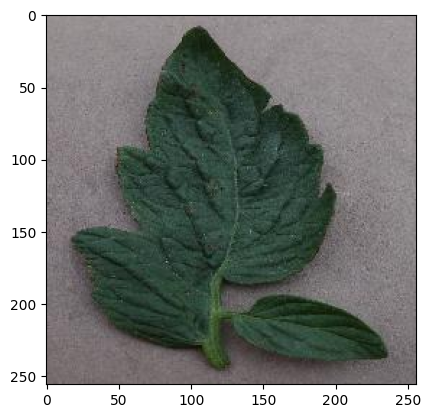

In [38]:
def show_image(image, label):
    print("Label: " + train_dataset.classes[label] + "(" + str(label) + ")")
    plt.imshow(image.permute(1, 2, 0))
    plt.show()
show_image(img, label)

Label: Tomato___Spider_mites Two-spotted_spider_mite(5)


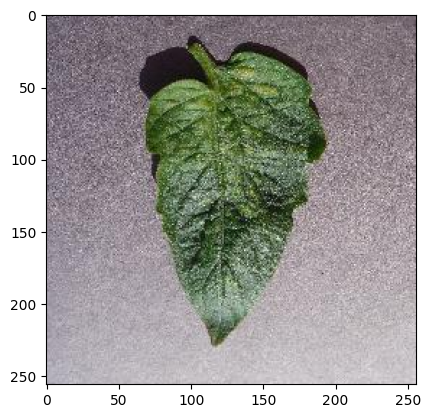

In [40]:
show_image(*train_dataset[10000])

In [41]:
# Setting the seed value
random_seed = 7
torch.manual_seed(random_seed)
# setting the batch size
batch_size = 32

In [42]:
# DataLoaders for training and validation
train_dl = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid_dataset, batch_size, num_workers=2, pin_memory=True)

In [43]:
# helper function to show a batch of training instances
def show_batch(data):
    for images, labels in data:
        fig, ax = plt.subplots(figsize=(30, 30))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break

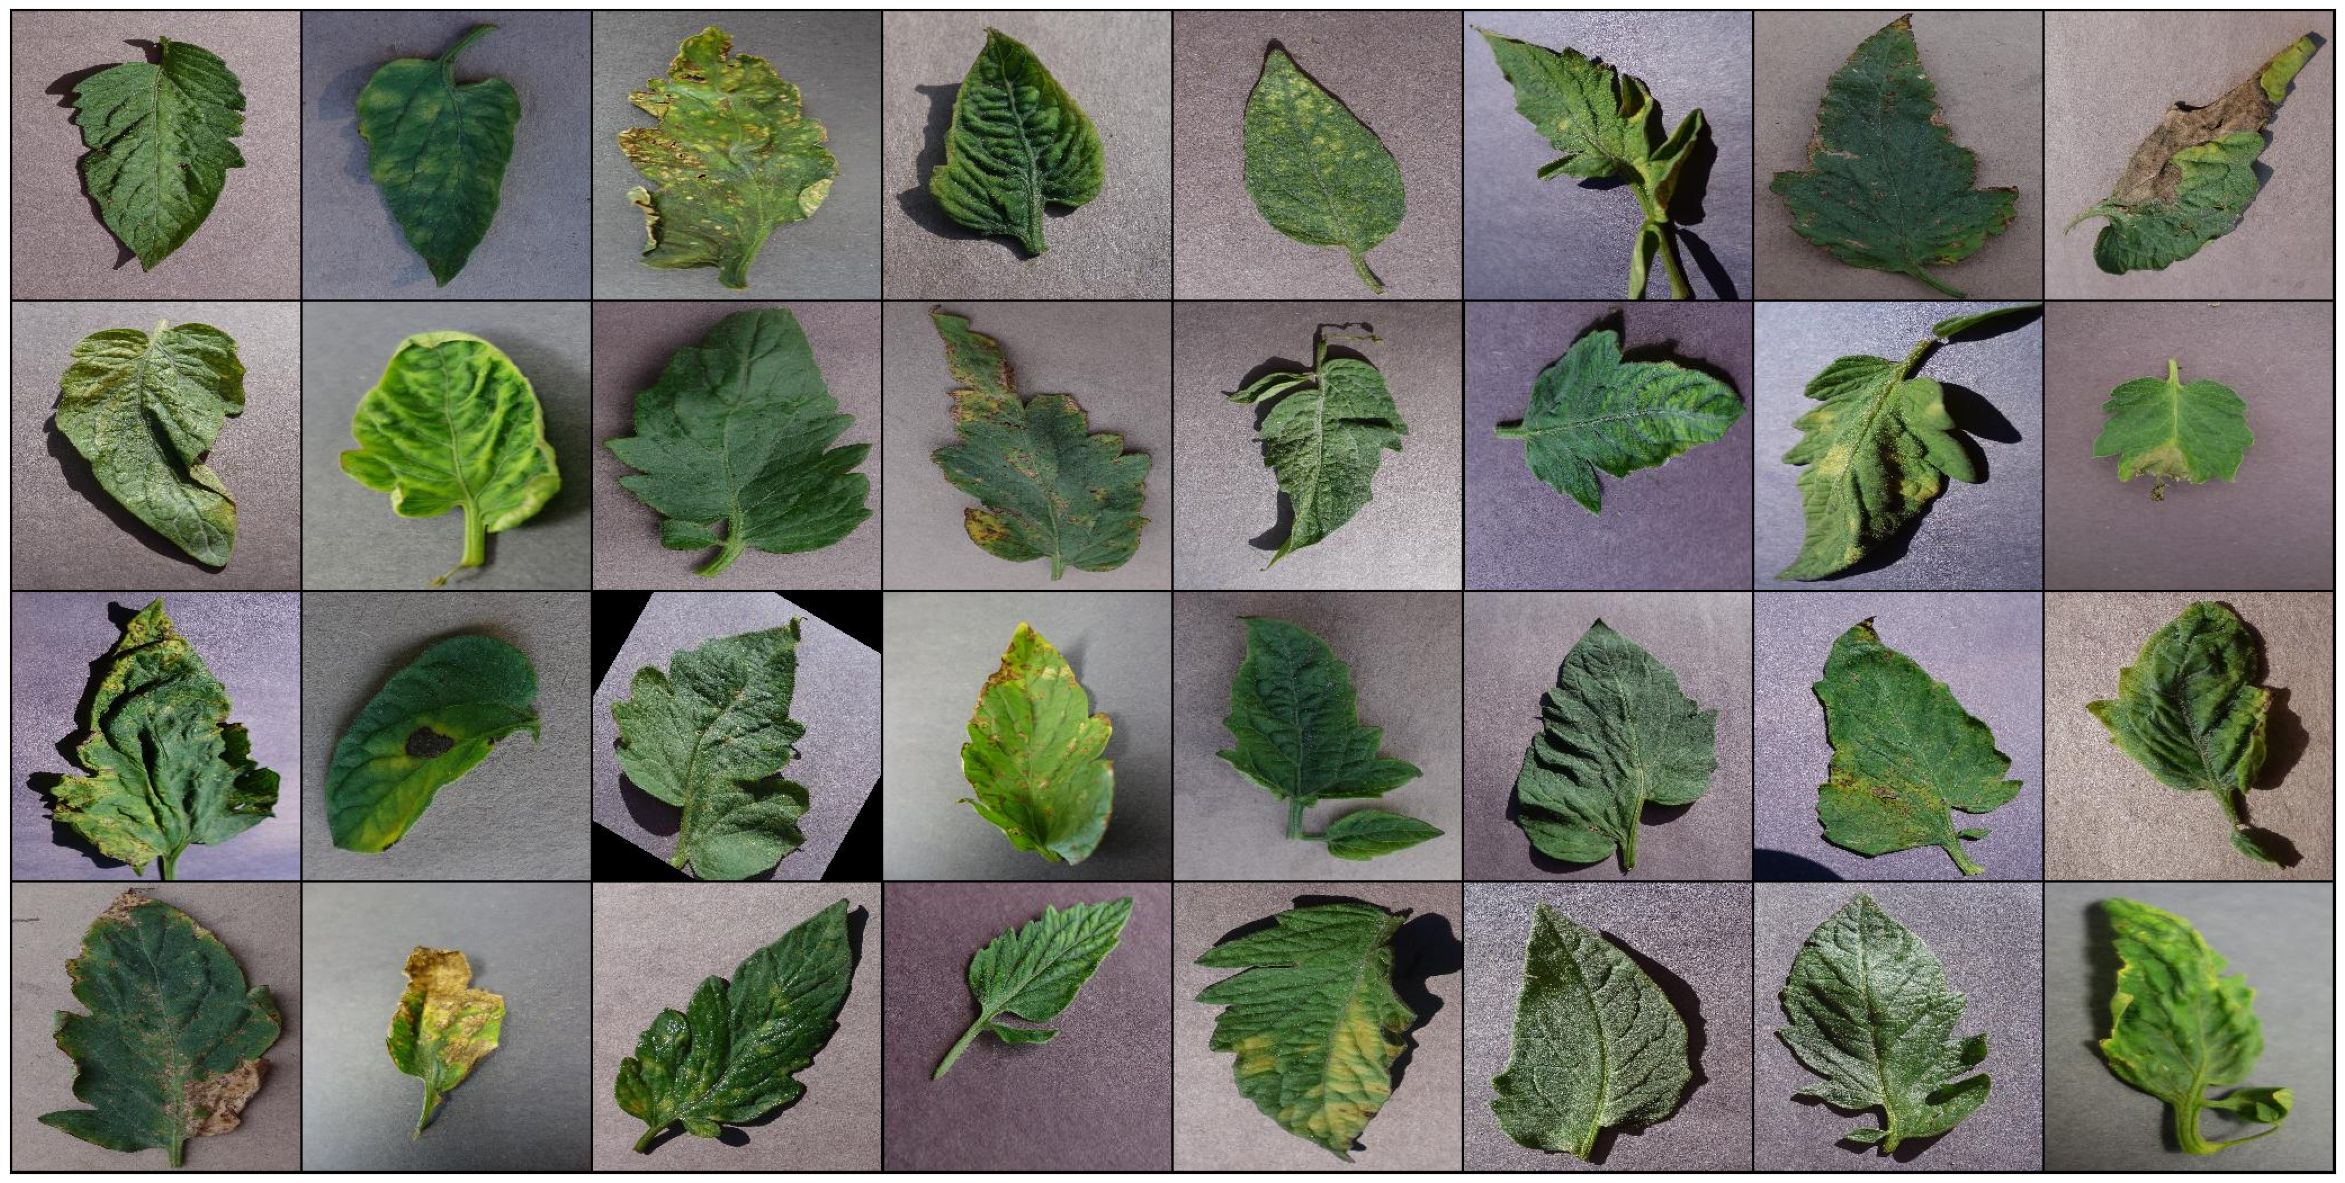

In [44]:
# Images for first batch of training
show_batch(train_dl)

In [45]:
# for moving data into GPU (if available)
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available:
        return torch.device("cuda")
    else:
        return torch.device("cpu")

# for moving data to device (CPU or GPU)
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

# for loading in the device (GPU if available else CPU)
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [46]:
device = get_default_device()
device

device(type='cuda')

In [47]:
# Moving data into GPU
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [48]:
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out) + x # ReLU can be applied before or after adding the input

In [49]:
# for calculating the accuracy
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


# base class for the model
class ImageClassificationBase(nn.Module):

    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                   # Generate prediction
        loss = F.cross_entropy(out, labels)  # Calculate loss
        acc = accuracy(out, labels)          # Calculate accuracy
        return {"val_loss": loss.detach(), "val_accuracy": acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x["val_loss"] for x in outputs]
        batch_accuracy = [x["val_accuracy"] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()       # Combine loss
        epoch_accuracy = torch.stack(batch_accuracy).mean()
        return {"val_loss": epoch_loss, "val_accuracy": epoch_accuracy} # Combine accuracies

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_accuracy']))


In [50]:
# Architecture for training

# convolution block with BatchNormalization
def ConvBlock(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
             nn.BatchNorm2d(out_channels),
             nn.ReLU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(4))
    return nn.Sequential(*layers)


# resnet architecture
class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_diseases):
        super().__init__()

        self.conv1 = ConvBlock(in_channels, 64)
        self.conv2 = ConvBlock(64, 128, pool=True) # out_dim : 128 x 64 x 64
        self.res1 = nn.Sequential(ConvBlock(128, 128), ConvBlock(128, 128))

        self.conv3 = ConvBlock(128, 256, pool=True) # out_dim : 256 x 16 x 16
        self.conv4 = ConvBlock(256, 512, pool=True) # out_dim : 512 x 4 x 44
        self.res2 = nn.Sequential(ConvBlock(512, 512), ConvBlock(512, 512))

        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                       nn.Flatten(),
                                       nn.Linear(512, num_diseases))

    def forward(self, xb): # xb is the loaded batch
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [58]:
# defining the model and moving it to the GPU
model = to_device(ResNet9(3, len(train_dataset.classes)), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

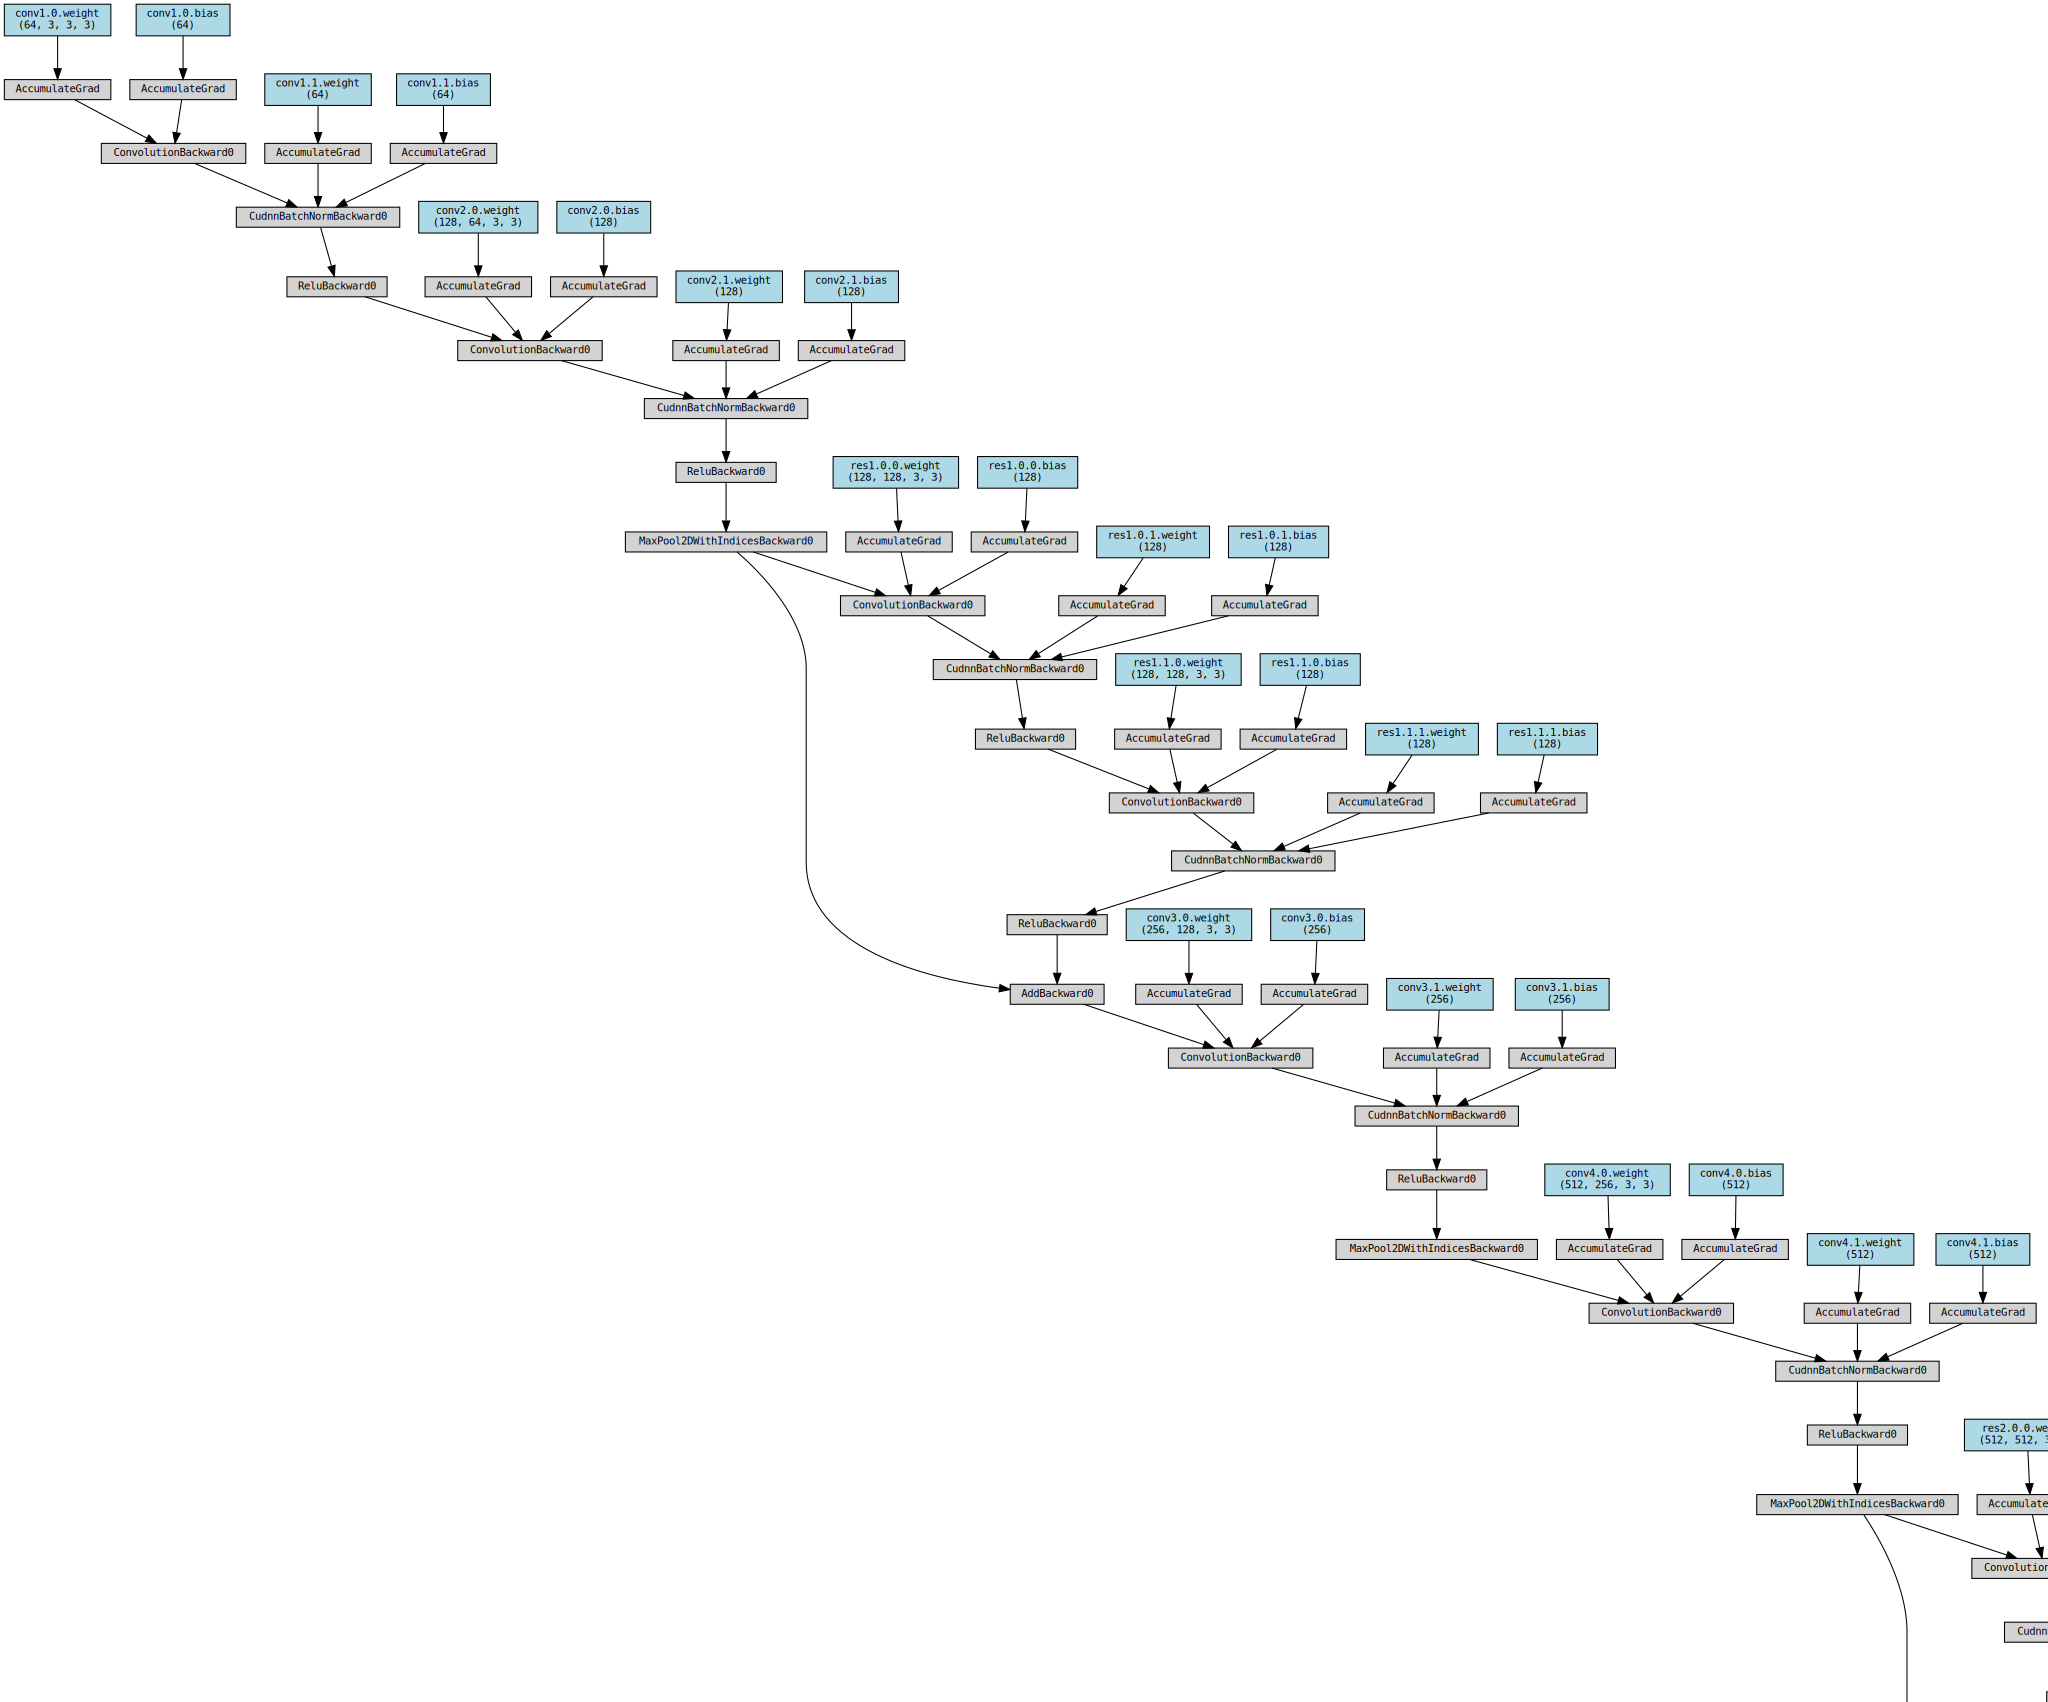

In [100]:
# Visualisasi arsitektur model
x = torch.randn(1, 3, 256, 256).to(device)
vis_model = ResNet9(3, len(train_dataset.classes)).to(device)
y = vis_model(x)
make_dot(y, params=dict(vis_model.named_parameters()))

In [101]:
dot = make_dot(y, params=dict(vis_model.named_parameters()))
dot.render('model_graph', format='png')

'model_graph.png'

In [59]:
# getting summary of the model
INPUT_SHAPE = (3, 256, 256)
print(summary(model.cuda(), (INPUT_SHAPE)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4        [-1, 128, 256, 256]          73,856
       BatchNorm2d-5        [-1, 128, 256, 256]             256
              ReLU-6        [-1, 128, 256, 256]               0
         MaxPool2d-7          [-1, 128, 64, 64]               0
            Conv2d-8          [-1, 128, 64, 64]         147,584
       BatchNorm2d-9          [-1, 128, 64, 64]             256
             ReLU-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 128, 64, 64]         147,584
      BatchNorm2d-12          [-1, 128, 64, 64]             256
             ReLU-13          [-1, 128, 64, 64]               0
           Conv2d-14          [-1, 256,

In [60]:
# for training
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


def fit_OneCycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0,
                grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # scheduler for one cycle learniing rate
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))


    for epoch in range(epochs):
        # Training
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # recording and updating learning rates
            lrs.append(get_lr(optimizer))
            sched.step()


        # validation
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)

    return history

In [61]:
%%time
history = [evaluate(model, valid_dl)]
history

CPU times: user 15.9 s, sys: 1.39 s, total: 17.3 s
Wall time: 18.7 s


[{'val_loss': tensor(2.3030, device='cuda:0'), 'val_accuracy': tensor(0.1063)}]

In [63]:
epochs = 5
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [64]:
%%time
history += fit_OneCycle(epochs, max_lr, model, train_dl, valid_dl,
                             grad_clip=grad_clip,
                             weight_decay=1e-4,
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00759, train_loss: 0.8068, val_loss: 5.2612, val_acc: 0.3750
Epoch [1], last_lr: 0.00950, train_loss: 0.5359, val_loss: 0.8138, val_acc: 0.7754
Epoch [2], last_lr: 0.00611, train_loss: 0.2074, val_loss: 0.3276, val_acc: 0.8965
Epoch [3], last_lr: 0.00188, train_loss: 0.1114, val_loss: 0.0431, val_acc: 0.9857
Epoch [4], last_lr: 0.00000, train_loss: 0.0205, val_loss: 0.0241, val_acc: 0.9922
CPU times: user 9min 32s, sys: 11min 10s, total: 20min 43s
Wall time: 21min 7s


In [69]:
def plot_accuracies(history):
    accuracies = [x['val_accuracy'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

def plot_losses(history):
    # Extracting train and validation losses from the history
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]

    # Ensure that losses are moved to CPU and converted to numpy if they are tensors
    train_losses = [loss.cpu().detach().numpy() if torch.is_tensor(loss) else loss for loss in train_losses]
    val_losses = [val.cpu().detach().numpy() if torch.is_tensor(val) else val for val in val_losses]

    # Plotting the losses
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of Epochs')
    plt.show()

def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

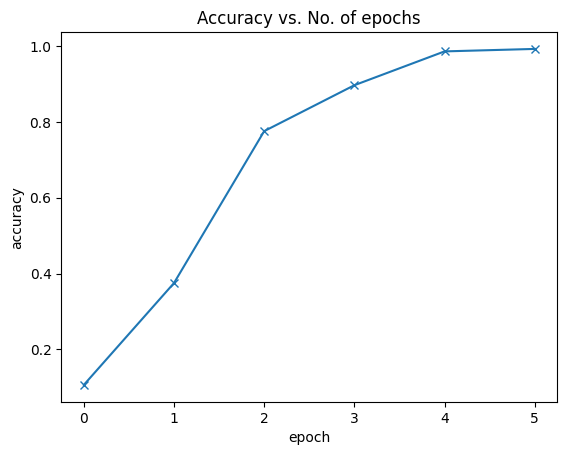

In [66]:
plot_accuracies(history)

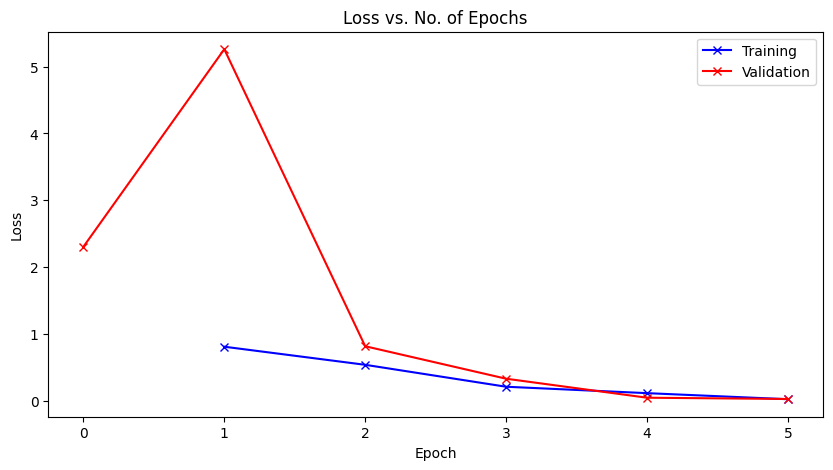

In [70]:
plot_losses(history)

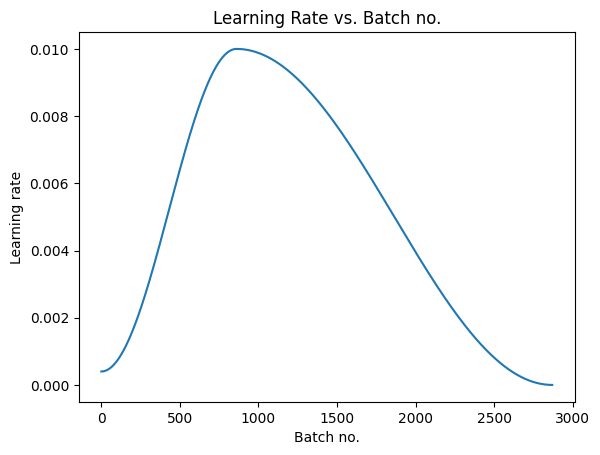

In [68]:
plot_lrs(history)

In [72]:
test_dir = "/content/test"
test = ImageFolder(test_dir, transform=transforms.ToTensor())

In [74]:
test_images = sorted(os.listdir(test_dir + '/test'))
tomato_test_images = [img for img in test_images if img.startswith('Tomato')]

print(tomato_test_images)

['TomatoEarlyBlight1.JPG', 'TomatoEarlyBlight2.JPG', 'TomatoEarlyBlight3.JPG', 'TomatoEarlyBlight4.JPG', 'TomatoEarlyBlight5.JPG', 'TomatoEarlyBlight6.JPG', 'TomatoHealthy1.JPG', 'TomatoHealthy2.JPG', 'TomatoHealthy3.JPG', 'TomatoHealthy4.JPG', 'TomatoYellowCurlVirus1.JPG', 'TomatoYellowCurlVirus2.JPG', 'TomatoYellowCurlVirus3.JPG', 'TomatoYellowCurlVirus4.JPG', 'TomatoYellowCurlVirus5.JPG', 'TomatoYellowCurlVirus6.JPG']


In [80]:
# Define a transformation (e.g., resizing and converting to tensor)
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

In [81]:
# Define a function to load and transform an image
def load_image(image_path):
    image = Image.open(image_path)
    return transform(image)

# Load and transform the tomato test images
tomato_test_images_transformed = [load_image(os.path.join(test_dir, 'test', img)) for img in tomato_test_images]


In [87]:
def predict_image(img, model, device):
    img = img.unsqueeze(0)  # Add batch dimension
    model.eval()
    with torch.no_grad():
        img = img.to(device)  # Move input tensor to the same device as the model
        preds = model(img)
    _, predicted = torch.max(preds, 1)
    return predicted

In [88]:
# Getting all predictions (actual label vs predicted)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)  # Move model to the same device as the input tensors


In [89]:
for i in range(len(tomato_test_images_transformed)):
    img = tomato_test_images_transformed[i]
    prediction = predict_image(img, model, device)
    print('Label:', tomato_test_images[i], ', Predicted:', train_dataset.classes[prediction.item()])

Label: TomatoEarlyBlight1.JPG , Predicted: Tomato___Early_blight
Label: TomatoEarlyBlight2.JPG , Predicted: Tomato___Early_blight
Label: TomatoEarlyBlight3.JPG , Predicted: Tomato___Early_blight
Label: TomatoEarlyBlight4.JPG , Predicted: Tomato___Early_blight
Label: TomatoEarlyBlight5.JPG , Predicted: Tomato___Early_blight
Label: TomatoEarlyBlight6.JPG , Predicted: Tomato___Early_blight
Label: TomatoHealthy1.JPG , Predicted: Tomato___healthy
Label: TomatoHealthy2.JPG , Predicted: Tomato___healthy
Label: TomatoHealthy3.JPG , Predicted: Tomato___healthy
Label: TomatoHealthy4.JPG , Predicted: Tomato___healthy
Label: TomatoYellowCurlVirus1.JPG , Predicted: Tomato___Tomato_Yellow_Leaf_Curl_Virus
Label: TomatoYellowCurlVirus2.JPG , Predicted: Tomato___Tomato_Yellow_Leaf_Curl_Virus
Label: TomatoYellowCurlVirus3.JPG , Predicted: Tomato___Tomato_Yellow_Leaf_Curl_Virus
Label: TomatoYellowCurlVirus4.JPG , Predicted: Tomato___Tomato_Yellow_Leaf_Curl_Virus
Label: TomatoYellowCurlVirus5.JPG , Predic

In [90]:
# saving to the kaggle working directory
PATH = './plant-disease-model-state-dict.pth'
torch.save(model.state_dict(), PATH)

In [91]:
# saving the entire model to working directory
PATH = './plant-disease-model-complete.pth'
torch.save(model, PATH)

In [1]:
from google.colab import files
files.download('/content/plant-disease-model-state-dict.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>